# Modelo Keras Secuencial


*   6 capas ocultas densas de 200, 500, 500, 1000, 1000, 2000 unidades
*   Activación  LeakyReLU(alpha=0.1)
*   Loss MSE
*   Métrica MAE
*   Adam Learning Rate 1e-2
*   15 epochs
*   Reentrenamiento 1e-4 50
*   Reentrenamiento 1e-6 1500



In [15]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import LeakyReLU
import keras.backend as K
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from sklearn.model_selection import train_test_split
from datetime import datetime

PATH = r'/content/drive/My Drive/Colab Notebooks/'
PATH_MODELS= r'/content/drive/My Drive/Colab Notebooks/models/'
DATA_INPUT_FILE= r'data_h2o_HF_ccpvdz.csv'
OUTPUT_FILES = r'keras_seq_adam_17'

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Carga de datos
17636 registros

In [4]:
data= pd.read_csv(PATH + DATA_INPUT_FILE, index_col= 0)
data.describe()

,rh1,rh2,ang,energia
count,17636.000000,17636.000000,17636.000000,17636.000000
mean,1.718462,1.718462,104.482706,-75.741635
std,0.465277,0.465277,4.329904,0.428579
min,0.800000,0.800000,94.500000,-76.027388
25%,1.400000,1.400000,102.500000,-75.992674
50%,1.708000,1.708000,104.500000,-75.924886
75%,2.025000,2.025000,106.500000,-75.722473
max,2.800000,2.800000,114.500000,-72.066162


# Transformación de las variables para el entrenamiento
*   x_input: Se normalizan las variables predictoras
*   y_input: Se le resta el mínimo a la variable objetivo


In [5]:
#Se normalizan las variables predictoras
x = data[['ang', 'rh1', 'rh2']].copy()
x_describe= x.describe()
x_stats = x_describe.transpose()
x_input = (x - x_stats['mean']) / x_stats['std']

# Se le resta el mínimo a la variable objetivo
minimo=min(data['energia'])
y_input = data['energia'].copy() -minimo


# Creación de los conjuntos de train y validación
Conjunto de validación del 10%

In [6]:
x_train, x_valid, y_train, y_valid = train_test_split(x_input, y_input , random_state = 33, test_size = 0.1)

# Definición de la arquitectura

In [16]:
#Modelo
model = keras.Sequential([
    layers.Dense(200, activation=LeakyReLU(alpha=0.1), input_shape=[len(x_train.keys())]),
    layers.Dense(500, activation=LeakyReLU(alpha=0.1)),
    layers.Dense(500, activation=LeakyReLU(alpha=0.1)),
    layers.Dense(1000, activation=LeakyReLU(alpha=0.1)),
    layers.Dense(1000, activation=LeakyReLU(alpha=0.1)),
    layers.Dense(2000, activation=LeakyReLU(alpha=0.1)),
    layers.Dense(1)
  ])

#Optimizador 
optimizer = keras.optimizers.Adam(learning_rate=1e-2)

model.compile( loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mean_squared_logarithmic_error'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 200)               800       
_________________________________________________________________
dense_8 (Dense)              (None, 500)               100500    
_________________________________________________________________
dense_9 (Dense)              (None, 500)               250500    
_________________________________________________________________
dense_10 (Dense)             (None, 1000)              501000    
_________________________________________________________________
dense_11 (Dense)             (None, 1000)              1001000   
_________________________________________________________________
dense_12 (Dense)             (None, 2000)              2002000   
_________________________________________________________________
dense_13 (Dense)             (None, 1)                

# Callback

In [17]:
#Se guarda el mejor modelo según la métrica de referencia MAE
callback_mejor_modelo = tf.keras.callbacks.ModelCheckpoint(
    filepath= PATH_MODELS + OUTPUT_FILES + r'_best.h5',
    monitor='val_mae',
    mode='min',
    save_best_only=True)

# Entrenamiento

In [18]:
EPOCHS = 15

datetime_comienzo = datetime.now()

#Entrenamiento
history = model.fit(
  x_train, y_train, verbose=0, 
  epochs=EPOCHS, validation_data=(x_valid, y_valid)
  ,callbacks=[callback_mejor_modelo])

datetime_fin = datetime.now()

#Se guarda el modelo
model.save(PATH_MODELS + OUTPUT_FILES + r'.h5',include_optimizer=True, save_format='h5')

print("Tiempo de entrenamiento:" + str(datetime_fin-datetime_comienzo) )

#Historia de entrenamiento a dataframe
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.to_csv(PATH_MODELS + 'hist' + OUTPUT_FILES + r'.csv',index=True)
hist.tail(5) 

Tiempo de entrenamiento:0:00:17.262496


,loss,mae,mean_squared_logarithmic_error,val_loss,val_mae,val_mean_squared_logarithmic_error,epoch
10,1.073103e+13,674139.750000,60.448242,2.720299e+09,37373.582031,43.049286,10
11,2.703749e+09,36603.945312,49.629776,1.245562e+09,25954.244141,34.708431,11
12,1.220279e+09,25211.431641,45.829277,7.105423e+08,19522.328125,47.654095,12
13,6.309790e+09,45567.667969,48.808483,9.456885e+09,58479.386719,96.523949,13
14,1.521097e+10,53047.722656,48.739651,1.461112e+10,96342.039062,2.338144,14


# Representación entrenamiento 

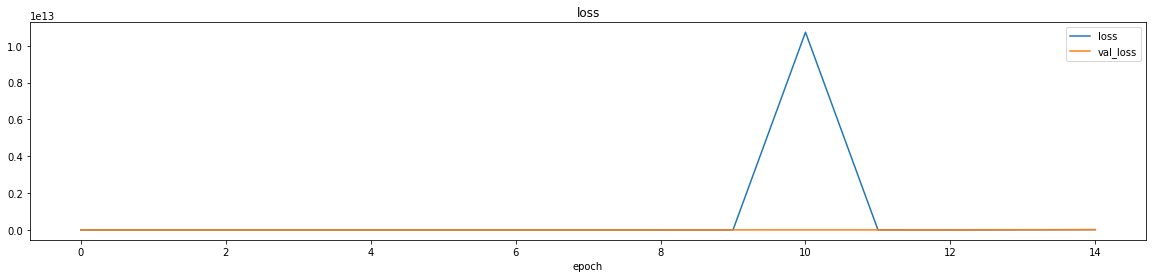

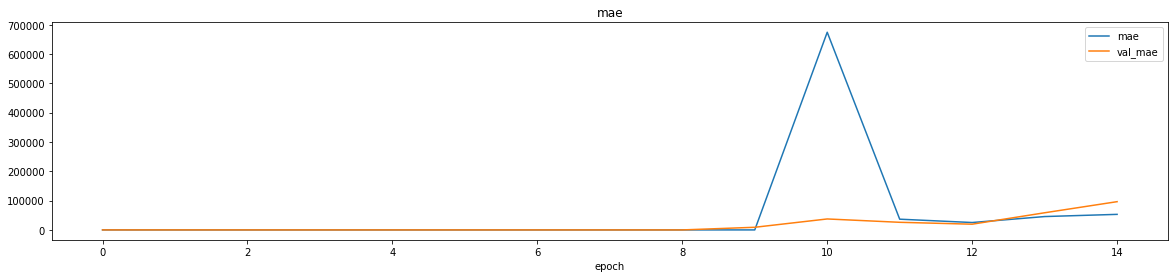

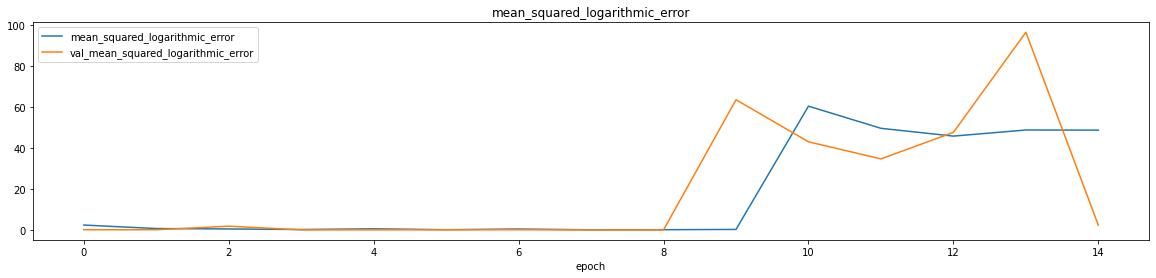

In [19]:
hist= pd.read_csv(PATH_MODELS + 'hist' + OUTPUT_FILES + r'.h5', index_col= 0)
hist.plot(x='epoch', y=['loss', 'val_loss'], title='loss', figsize=(20,4))
hist.plot(x='epoch', y=['mae', 'val_mae'], title='mae', figsize=(20,4))
hist.plot(x='epoch', y=['mean_squared_logarithmic_error', 'val_mean_squared_logarithmic_error'], title='mean_squared_logarithmic_error', figsize=(20,4))

# Representación entrenamiento 
A partir del epoch 200 para aumentar escala vertical

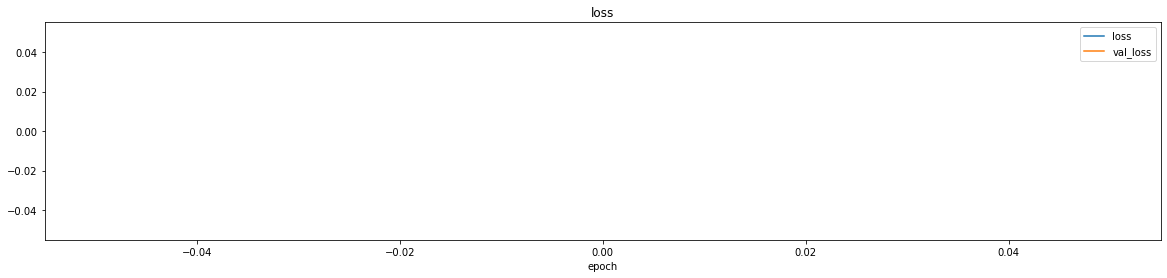

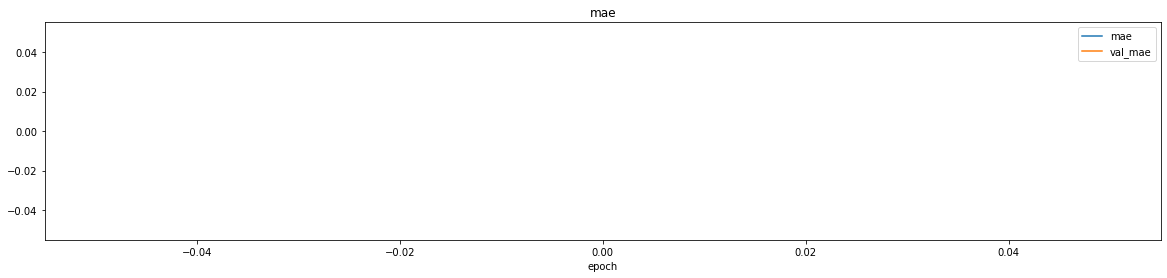

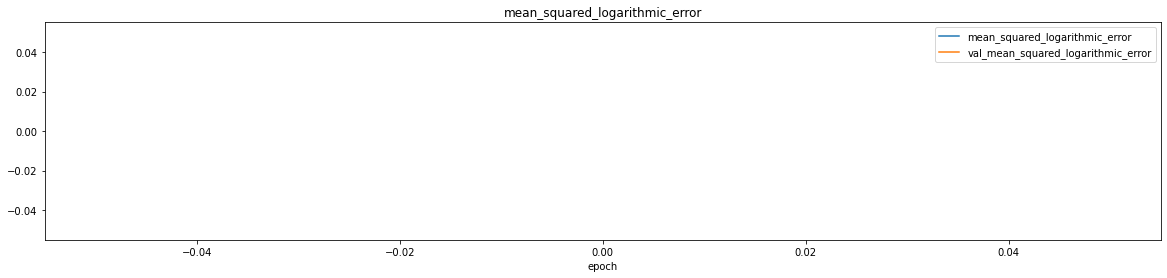

In [20]:
hist_mayor_200= hist[(hist['epoch']>=200)]
hist_mayor_200.plot(x='epoch', y=['loss', 'val_loss'], title='loss', figsize=(20,4))
hist_mayor_200.plot(x='epoch', y=['mae', 'val_mae'], title='mae', figsize=(20,4))
hist_mayor_200.plot(x='epoch', y=['mean_squared_logarithmic_error', 'val_mean_squared_logarithmic_error'], title='mean_squared_logarithmic_error', figsize=(20,4))

# Mejores épocas

In [21]:

indice_min_loss =hist['val_loss'].idxmin()
indice_min_mae =hist['val_mae'].idxmin()
indice_min_msle =hist['val_mean_squared_logarithmic_error'].idxmin()

print('Loss (MSE) mínimo: epoch {} valor {:.3E}'.format(hist['epoch'][indice_min_loss],hist['val_loss'][indice_min_loss]))
print('MAE mínimo: epoch {} valor {:.3E}'.format(hist['epoch'][indice_min_mae],hist['val_mae'][indice_min_mae]))
print('MSLE mínimo: epoch {} valor {:.3E}'.format(hist['epoch'][indice_min_msle],hist['val_mean_squared_logarithmic_error'][indice_min_msle]))


Loss (MSE) mínimo: epoch 8 valor 1.049E-01
MAE mínimo: epoch 8 valor 2.239E-01
MSLE mínimo: epoch 8 valor 3.870E-02


# Cargamos el mejor modelo
Y comprobamos que la evaluación corresponde a la mejor época de la métrica de referencia MAE

In [24]:
model_best = keras.models.load_model(PATH_MODELS + OUTPUT_FILES + r'_best.h5',
                                      custom_objects = {"LeakyReLU": LeakyReLU})
model_best.evaluate(x_valid, y_valid, verbose=2)

56/56 - 0s - loss: 0.1049 - mean_absolute_error: 0.2239 - mean_squared_logarithmic_error: 0.0387


[0.1049339771270752, 0.22388899326324463, 0.03870160132646561]

# Reentrenamiento 1

In [25]:
EPOCHS = 200

model_reen1 = model_best
K.set_value(model_reen1.optimizer.learning_rate, 1e-4)

#Se guarda el mejor modelo según la métrica de referencia MAE
callback_mejor_modelo_reen1 = tf.keras.callbacks.ModelCheckpoint(
    filepath= PATH_MODELS + OUTPUT_FILES + r'_reen1_best.h5',
    monitor='val_mean_absolute_error',
    mode='min',
    save_best_only=True)

datetime_comienzo = datetime.now()

#Entrenamiento
history_reen1 = model_reen1.fit(
  x_train, y_train, verbose=0, 
  epochs=EPOCHS, validation_data=(x_valid, y_valid)
  ,callbacks=[callback_mejor_modelo_reen1])

datetime_fin = datetime.now()

#Se guarda el modelo
model_reen1.save(PATH_MODELS + OUTPUT_FILES + r'_reen1.h5',include_optimizer=True, save_format='h5')

print("Tiempo de entrenamiento:" + str(datetime_fin-datetime_comienzo) )

#Historia de entrenamiento a dataframe
hist_reen1 = pd.DataFrame(history_reen1.history)
hist_reen1['epoch'] = history_reen1.epoch
hist_reen1.to_csv(PATH_MODELS + 'hist' + OUTPUT_FILES + r'_reen1.csv',index=True)
hist_reen1.tail(5) 

Tiempo de entrenamiento:0:03:35.947221


,loss,mean_absolute_error,mean_squared_logarithmic_error,val_loss,val_mean_absolute_error,val_mean_squared_logarithmic_error,epoch
195,0.000927,0.015077,0.000299,0.000402,0.015470,0.000188,195
196,0.000779,0.014071,0.000267,0.000132,0.008237,0.000064,196
197,0.000850,0.014198,0.000272,0.000381,0.014817,0.000245,197
198,0.078408,0.048271,0.003938,0.044775,0.165939,0.014983,198
199,0.005396,0.051207,0.002521,0.001620,0.027722,0.000724,199


In [31]:
model_reen1_best = keras.models.load_model(PATH_MODELS + OUTPUT_FILES + r'_reen1_best.h5',
                                      custom_objects = {"LeakyReLU": LeakyReLU})
model_reen1_best.evaluate(x_valid, y_valid, verbose=2)

56/56 - 0s - loss: 1.0796e-04 - mean_absolute_error: 0.0071 - mean_squared_logarithmic_error: 4.7919e-05


[0.0001079611829482019, 0.007082828786224127, 4.7918652853695676e-05]

# Reentrenamiento 2

In [32]:
EPOCHS = 1500

model_reen2 = model_reen1_best
K.set_value(model_reen2.optimizer.learning_rate, 1e-6)

#Se guarda el mejor modelo según la métrica de referencia MAE
callback_mejor_modelo_reen2 = tf.keras.callbacks.ModelCheckpoint(
    filepath= PATH_MODELS + OUTPUT_FILES + r'_reen2_best.h5',
    monitor='val_mean_absolute_error',
    mode='min',
    save_best_only=True)

datetime_comienzo = datetime.now()

#Entrenamiento
history_reen2 = model_reen2.fit(
  x_train, y_train, verbose=0, 
  epochs=EPOCHS, validation_data=(x_valid, y_valid)
  ,callbacks=[callback_mejor_modelo_reen2])

datetime_fin = datetime.now()

#Se guarda el modelo
model_reen2.save(PATH_MODELS + OUTPUT_FILES + r'_reen2.h5',include_optimizer=True, save_format='h5')

print("Tiempo de entrenamiento:" + str(datetime_fin-datetime_comienzo) )

#Historia de entrenamiento a dataframe
hist_reen2 = pd.DataFrame(history_reen2.history)
hist_reen2['epoch'] = history_reen2.epoch
hist_reen2.to_csv(PATH_MODELS + 'hist' + OUTPUT_FILES + r'_reen2.csv',index=True)
hist_reen2.tail(5) 

Tiempo de entrenamiento:0:26:47.680815


,loss,mean_absolute_error,mean_squared_logarithmic_error,val_loss,val_mean_absolute_error,val_mean_squared_logarithmic_error,epoch
1495,0.000246,0.003805,0.000043,0.000030,0.003443,0.000011,1495
1496,0.000250,0.003769,0.000045,0.000030,0.003366,0.000011,1496
1497,0.000247,0.003709,0.000043,0.000070,0.006301,0.000034,1497
1498,0.000244,0.003771,0.000043,0.000039,0.003698,0.000014,1498
1499,0.000248,0.003802,0.000044,0.000036,0.004110,0.000016,1499


#Representación entrenamiento final

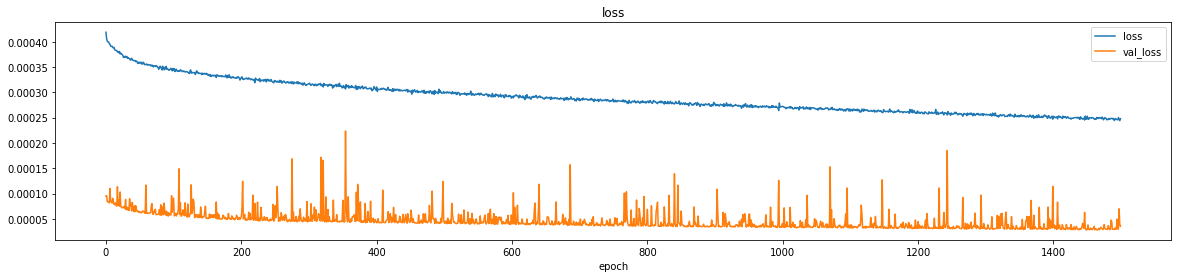

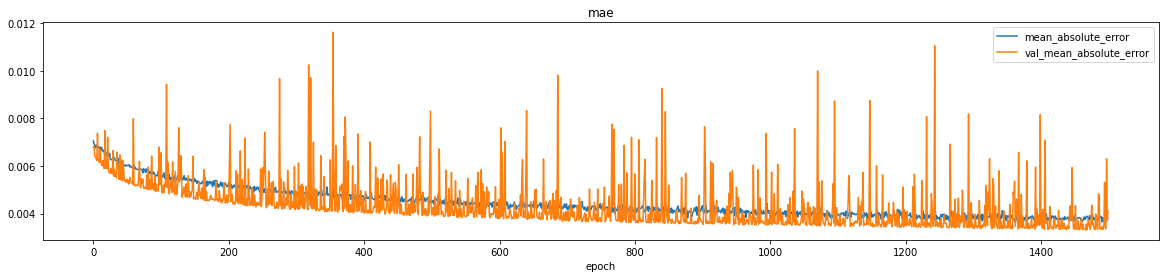

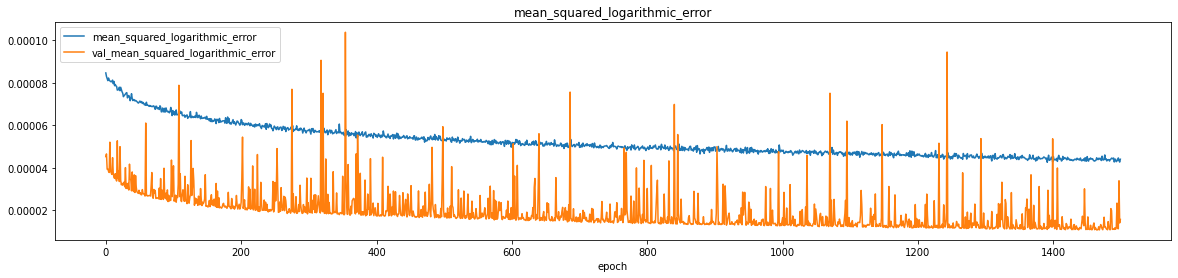

In [35]:
hist_reen2= pd.read_csv(PATH_MODELS + 'hist' + OUTPUT_FILES + r'_reen2.h5', index_col= 0)
hist_reen2.plot(x='epoch', y=['loss', 'val_loss'], title='loss', figsize=(20,4))
hist_reen2.plot(x='epoch', y=['mean_absolute_error', 'val_mean_absolute_error'], title='mae', figsize=(20,4))
hist_reen2.plot(x='epoch', y=['mean_squared_logarithmic_error', 'val_mean_squared_logarithmic_error'], title='mean_squared_logarithmic_error', figsize=(20,4))

In [36]:
model_reen2_best = keras.models.load_model(PATH_MODELS + OUTPUT_FILES + r'_reen2_best.h5',
                           custom_objects = {"LeakyReLU": LeakyReLU})
model_reen2_best.evaluate(x_valid, y_valid, verbose=2)

56/56 - 0s - loss: 2.8956e-05 - mean_absolute_error: 0.0033 - mean_squared_logarithmic_error: 1.0934e-05


[2.89558302029036e-05, 0.0033112044911831617, 1.0934331839962397e-05]

# Test del modelo con dataset independiente

In [37]:
data_test = pd.read_csv("/content/drive/My Drive/Colab Notebooks/output_plotdata_ccpvdz_HF_test.csv")

y_test = data_test.pop("energia")
x_test = data_test

y_test_input = y_test - minimo
x_test_input = (x_test - x_stats['mean']) / x_stats['std']

model_best.evaluate(x_test_input, y_test_input, verbose=2)

50/50 - 0s - loss: 0.0015 - mean_absolute_error: 0.0246 - mean_squared_logarithmic_error: 9.2282e-04


[0.0014786770334467292, 0.024568503722548485, 0.0009228167473338544]

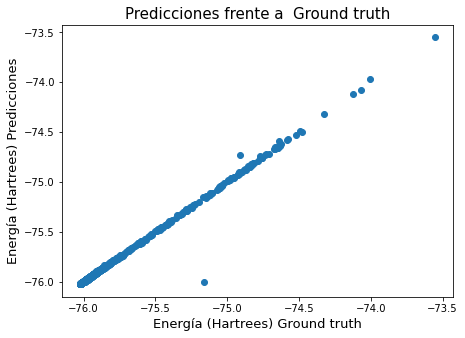

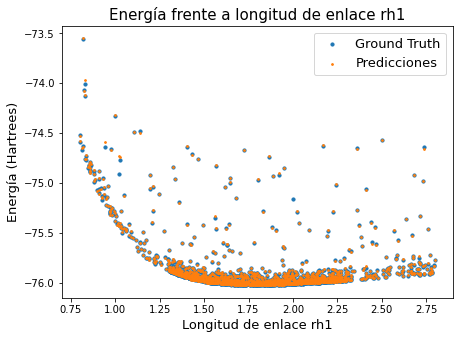

In [38]:
test_predictions = model_reen2_best.predict(x_test_input).flatten() 

fig, ax = plt.subplots(figsize=(7,5))
ax.scatter(y_test, test_predictions + minimo)
ax.set_title('Predicciones frente a  Ground truth', fontsize=15)
ax.set_xlabel('Energía (Hartrees) Ground truth', fontsize=13)
ax.set_ylabel('Energía (Hartrees) Predicciones', fontsize=13)

fig, ax = plt.subplots(figsize=(7,5))
ax.scatter(x_test['rh1'], y_test, label='Ground Truth', s=10)
ax.scatter(x_test['rh1'], test_predictions + minimo, label='Predicciones', s=3)
ax.set_title('Energía frente a longitud de enlace rh1', fontsize=15)
ax.set_xlabel('Longitud de enlace rh1', fontsize=13)
ax.set_ylabel('Energía (Hartrees)', fontsize=13)
ax.legend(fontsize=13)
plt.show()

# Energía frente a una distancia de enlace
Fijando la otra distancia de enlace a 1.808 ua y el ángulo a 104.5 grados

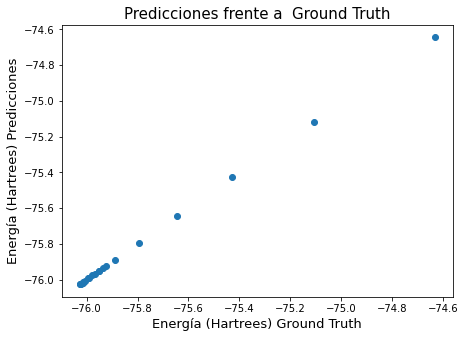

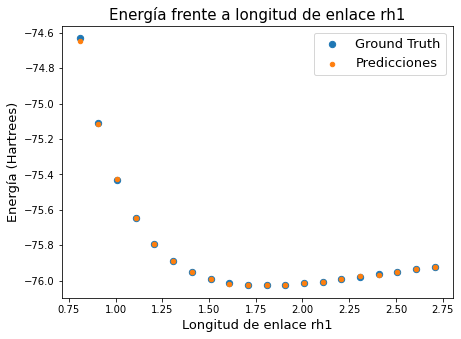

In [39]:
x_long_enlace = data[(np.round(data["ang"],1)==104.5) & (np.round(data["rh2"],3)==1.808)].copy()
y_long_enlace =x_long_enlace.pop("energia")
x_long_enlace_input = (x_long_enlace - x_stats['mean']) / x_stats['std']

test_predictions_long_enlace = model_reen2_best.predict(x_long_enlace_input).flatten()
fig, ax = plt.subplots(figsize=(7,5))
ax.scatter(y_long_enlace, test_predictions_long_enlace + minimo)
ax.set_title('Predicciones frente a  Ground Truth', fontsize=15)
ax.set_xlabel('Energía (Hartrees) Ground Truth', fontsize=13)
ax.set_ylabel('Energía (Hartrees) Predicciones', fontsize=13)


fig, ax = plt.subplots(figsize=(7,5))
ax.scatter(x_long_enlace['rh1'], y_long_enlace, label='Ground Truth', s=40)
ax.scatter(x_long_enlace['rh1'], test_predictions_long_enlace + minimo, label='Predicciones', s=20)
ax.set_title('Energía frente a longitud de enlace rh1', fontsize=15)
ax.set_xlabel('Longitud de enlace rh1', fontsize=13)
ax.set_ylabel('Energía (Hartrees)', fontsize=13)
ax.legend(fontsize=13)
plt.show()




plt.show()

# Energía frente al ángulo
Fijando las dos distancias de enelace a 1.808

Ángulo en el vértice de la parábola: 107.16


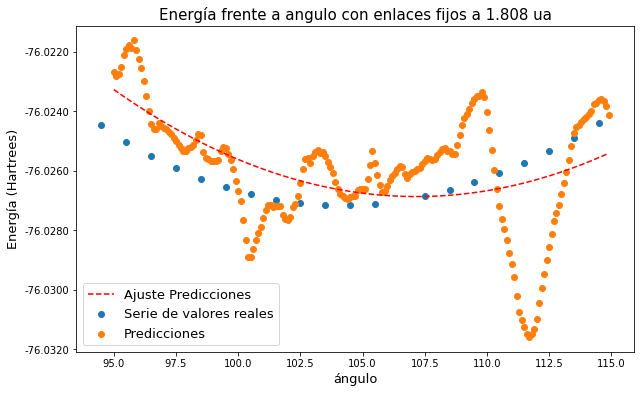

In [40]:
x_data_ang = data[(np.round(data['rh1'],3)==1.808) & (np.round(data['rh2'],3)==1.808)].copy()
y_data_ang =x_data_ang.pop("energia")

x_arange = pd.DataFrame()
x_arange['ang']= np.arange(95, 115, 0.1)
x_arange['rh1'] =1.808
x_arange['rh2'] =1.808
x_arange_input = (x_arange - x_stats['mean']) / x_stats['std']
test_predictions_arrange_ang = model_reen2_best.predict(x_arange_input).flatten()

z = np.polyfit(x_arange['ang'], test_predictions_arrange_ang + minimo, 2)
p = np.poly1d(z)
ang_vertice = -p.coefficients[1]/(2*p.coefficients[0])
print('Ángulo en el vértice de la parábola: {:.2f}'.format(ang_vertice))


fig, ax = plt.subplots(figsize=(10,6))

ax.scatter(x_data_ang['ang'], y_data_ang , label='Serie de valores reales')
ax.scatter(x_arange['ang'], test_predictions_arrange_ang + minimo, label='Predicciones')
ax.plot(x_arange['ang'],p(x_arange['ang']),"r--", label= 'Ajuste Predicciones')
ax.set_title('Energía frente a angulo con enlaces fijos a 1.808 ua', fontsize=15)
ax.set_xlabel('ángulo', fontsize=13)
ax.set_ylabel('Energía (Hartrees)', fontsize=13)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
ax.legend(fontsize=13)

plt.show()



Fijando las dos distancias de enelace a 1.708



Ángulo en el vértice de la parábola: 105.00


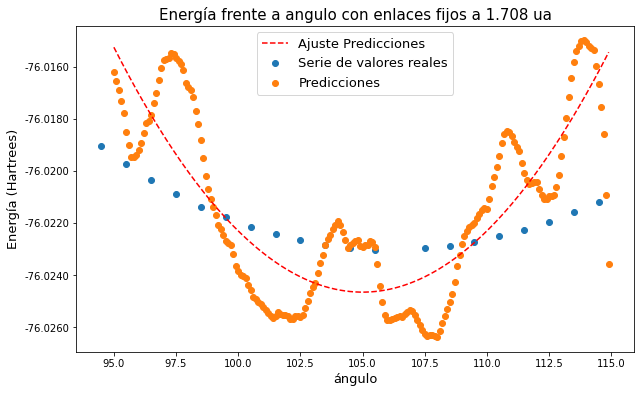

In [41]:
x_data_ang = data[(np.round(data['rh1'],3)==1.708) & (np.round(data['rh2'],3)==1.708)].copy()
y_data_ang =x_data_ang.pop("energia")

x_arange = pd.DataFrame()
x_arange['ang']= np.arange(95, 115, 0.1)
x_arange['rh1'] =1.708
x_arange['rh2'] =1.708
x_arange_input = (x_arange - x_stats['mean']) / x_stats['std']
test_predictions_arrange_ang = model_reen2_best.predict(x_arange_input).flatten()

z = np.polyfit(x_arange['ang'], test_predictions_arrange_ang + minimo, 2)
p = np.poly1d(z)
ang_vertice = -p.coefficients[1]/(2*p.coefficients[0])
print('Ángulo en el vértice de la parábola: {:.2f}'.format(ang_vertice))


fig, ax = plt.subplots(figsize=(10,6))

ax.scatter(x_data_ang['ang'], y_data_ang , label='Serie de valores reales')
ax.scatter(x_arange['ang'], test_predictions_arrange_ang + minimo, label='Predicciones')
ax.plot(x_arange['ang'],p(x_arange['ang']),"r--", label= 'Ajuste Predicciones')
ax.set_title('Energía frente a angulo con enlaces fijos a 1.708 ua', fontsize=15)
ax.set_xlabel('ángulo', fontsize=13)
ax.set_ylabel('Energía (Hartrees)', fontsize=13)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
ax.legend(fontsize=13)

plt.show()